In [ ]:
pip install yfinance pandas numpy scikit-learn tensorflow matplotlib


In [ ]:
from tensorflow import keras
from tensorflow.keras.models import Sequential

# Importing YFinance Dataset:

/tmp/ipython-input-3781720237.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download('AAPL', start='2020-01-01', end='2024-12-31')
[*********************100%***********************]  1 of 1 completed


First 5 rows of the dataset:
Price           Close       High        Low       Open     Volume
Ticker           AAPL       AAPL       AAPL       AAPL       AAPL
Date                                                             
2020-01-02  72.538506  72.598884  71.292296  71.545882  135480400
2020-01-03  71.833282  72.594048  71.608677  71.765659  146322800
2020-01-06  72.405670  72.444313  70.703005  70.954181  118387200
2020-01-07  72.065155  72.671348  71.845377  72.415345  108872000
2020-01-08  73.224442  73.526333  71.768116  71.768116  132079200

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1257 entries, 2020-01-02 to 2024-12-30
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   (Close, AAPL)   1257 non-null   float64
 1   (High, AAPL)    1257 non-null   float64
 2   (Low, AAPL)     1257 non-null   float64
 3   (Open, AAPL)    1257 non-null   float64
 4   (Volume, AAPL)  1257 n

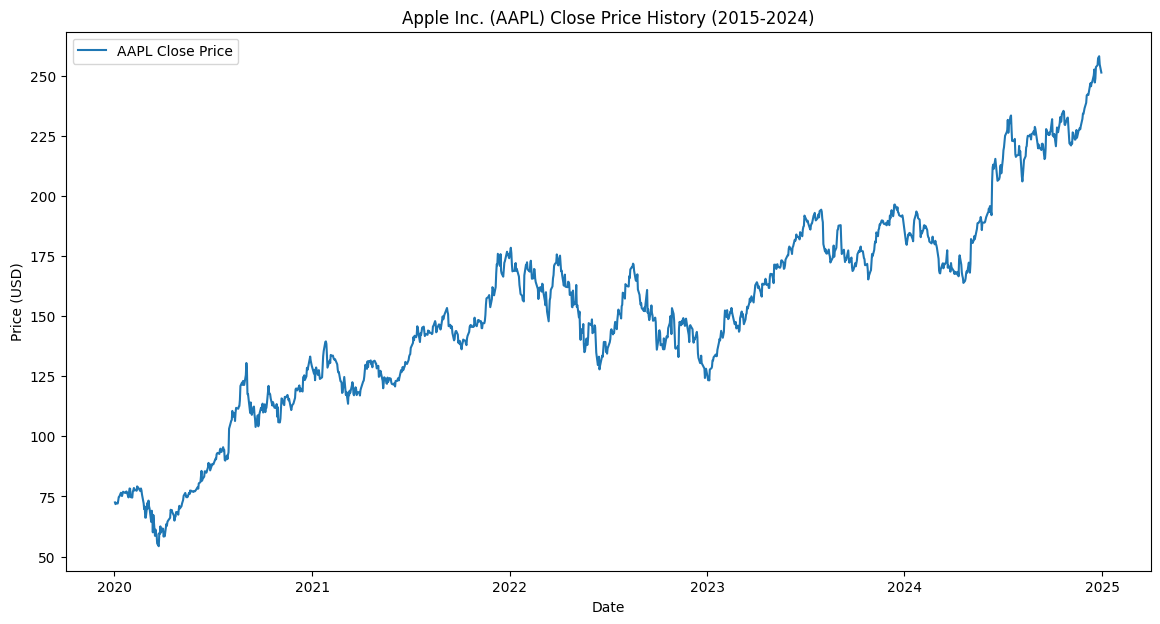

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# Import TensorFlow and Keras components
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Flatten


# Fetch data for Apple Inc. (AAPL) from 2015 to the end of 2024
df = yf.download('AAPL', start='2020-01-01', end='2024-12-31')

print("First 5 rows of the dataset:")
print(df.head())
print("\nDataset Information:")
df.info()

# Plot the closing price history
plt.figure(figsize=(14, 7))
plt.plot(df['Close'], label='AAPL Close Price')
plt.title('Apple Inc. (AAPL) Close Price History (2015-2024)')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()


Dataset with engineered features (last 5 rows):
Price            Close      SMA_20      SMA_50      EMA_20        RSI
Ticker            AAPL                                               
Date                                                                 
2024-12-23  254.367035  244.160250  234.447658  244.586378  73.865399
2024-12-24  257.286682  245.422272  234.988821  245.795931  76.180671
2024-12-26  258.103729  246.616033  235.495562  246.968102  76.812095
2024-12-27  254.685883  247.645380  235.975154  247.703129  69.300689
2024-12-30  251.307861  248.386250  236.379820  248.046436  58.382033


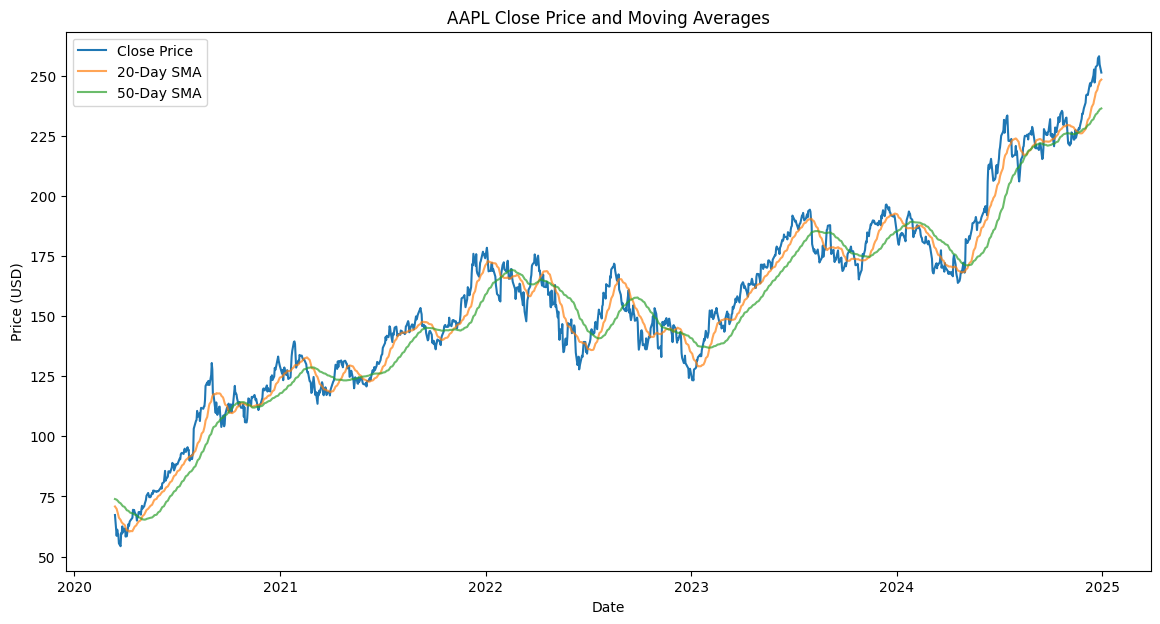

In [ ]:
# Feature Engineering
# Simple Moving Averages
df['SMA_20'] = df['Close'].rolling(window=20).mean()
df['SMA_50'] = df['Close'].rolling(window=50).mean()

# Exponential Moving Average
df['EMA_20'] = df['Close'].ewm(span=20, adjust=False).mean()

# Relative Strength Index (RSI)
delta = df['Close'].diff()
gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
rs = gain / loss
df['RSI'] = 100 - (100 / (1 + rs))

# Drop missing values created by rolling windows
df.dropna(inplace=True)

# Select features and target
features = ['Close', 'SMA_20', 'SMA_50', 'EMA_20', 'RSI']
target = 'Close'

print("\nDataset with engineered features (last 5 rows):")
print(df[features].tail())

# Plot Close price with Moving Averages
plt.figure(figsize=(14, 7))
plt.plot(df['Close'], label='Close Price')
plt.plot(df['SMA_20'], label='20-Day SMA', alpha=0.7)
plt.plot(df['SMA_50'], label='50-Day SMA', alpha=0.7)
plt.title('AAPL Close Price and Moving Averages')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()

In [ ]:
# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df[features])

# Create sequences
def create_sequences(data, time_steps=60):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:(i + time_steps)])
        # The target is the 'Close' price of the next day (index 0)
        y.append(data[i + time_steps, 0])
    return np.array(X), np.array(y)

TIME_STEPS = 30
X, y = create_sequences(scaled_data, TIME_STEPS)

# Split data into training and testing sets (80-20 split)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print(f"\nShape of X_train: {X_train.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_test: {y_test.shape}")


Shape of X_train: (942, 30, 5)
Shape of y_train: (942,)
Shape of X_test: (236, 30, 5)
Shape of y_test: (236,)


# ANN Model:

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

ann_model = Sequential([

    Flatten(input_shape=(X_train.shape[1], X_train.shape[2])),

    Dense(256, activation='relu'),
    Dropout(0.2),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dense(1)
])


ann_model.compile(optimizer='adam', loss='mean_squared_error')

early_stopper = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

history = ann_model.fit(
    X_train,
    y_train,
    epochs=100,
    batch_size=128,
    validation_split=0.2,
    callbacks=[early_stopper],
    verbose=1
)

Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - loss: 0.1311 - val_loss: 0.1114
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0325 - val_loss: 0.0023
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0172 - val_loss: 0.0571
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0112 - val_loss: 0.0156
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0087 - val_loss: 0.0264
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0069 - val_loss: 0.0329
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0060 - val_loss: 0.0188
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0053 - val_loss: 0.0324
Epoch 9/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0053 - val_loss: 0.0242
Epoch 10/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0043 - val_loss: 0.0330
Epoch 11/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0039 - val_loss: 0.0277
Epoch 12/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0037 - val_loss: 0.0301


# LSTM Model:

In [ ]:
# --- LSTM Model ---
lstm_model = Sequential([
    LSTM(100, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    LSTM(100, return_sequences=True),
    Dropout(0.2),
    LSTM(100, return_sequences=False),
    Dropout(0.2),
    Dense(25, activation='relu'),
    Dense(1) # Output layer
])

lstm_model.compile(optimizer='adam', loss='mean_squared_error')
print("\n--- Training LSTM Model ---")
lstm_history = lstm_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.1, verbose=1,callbacks=[keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)])


--- Training LSTM Model ---
Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 8s 98ms/step - loss: 0.0512 - val_loss: 0.0012
Epoch 2/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 115ms/step - loss: 0.0035 - val_loss: 0.0022
Epoch 3/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 77ms/step - loss: 0.0024 - val_loss: 0.0057
Epoch 4/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - loss: 0.0024 - val_loss: 0.0045
Epoch 5/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - loss: 0.0019 - val_loss: 0.0020
Epoch 6/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0017 - val_loss: 0.0011
Epoch 7/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - loss: 0.0019 - val_loss: 0.0011
Epoch 8/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - loss: 0.0019 - val_loss: 0.0016
Epoch 9/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 76ms/step - loss: 0.0020 - val_loss: 0.0014
Epoch 10/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 76ms/step - loss: 0.0016 - val_loss: 0.0033
Epoch 11/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 78ms/step - loss: 0.0018 - val_loss: 0.0011
Epoch 12/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 120ms/step - loss: 0.0018 - va

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step

--- Model Performance ---
ANN Model RMSE: $8.27
LSTM Model RMSE: $5.78


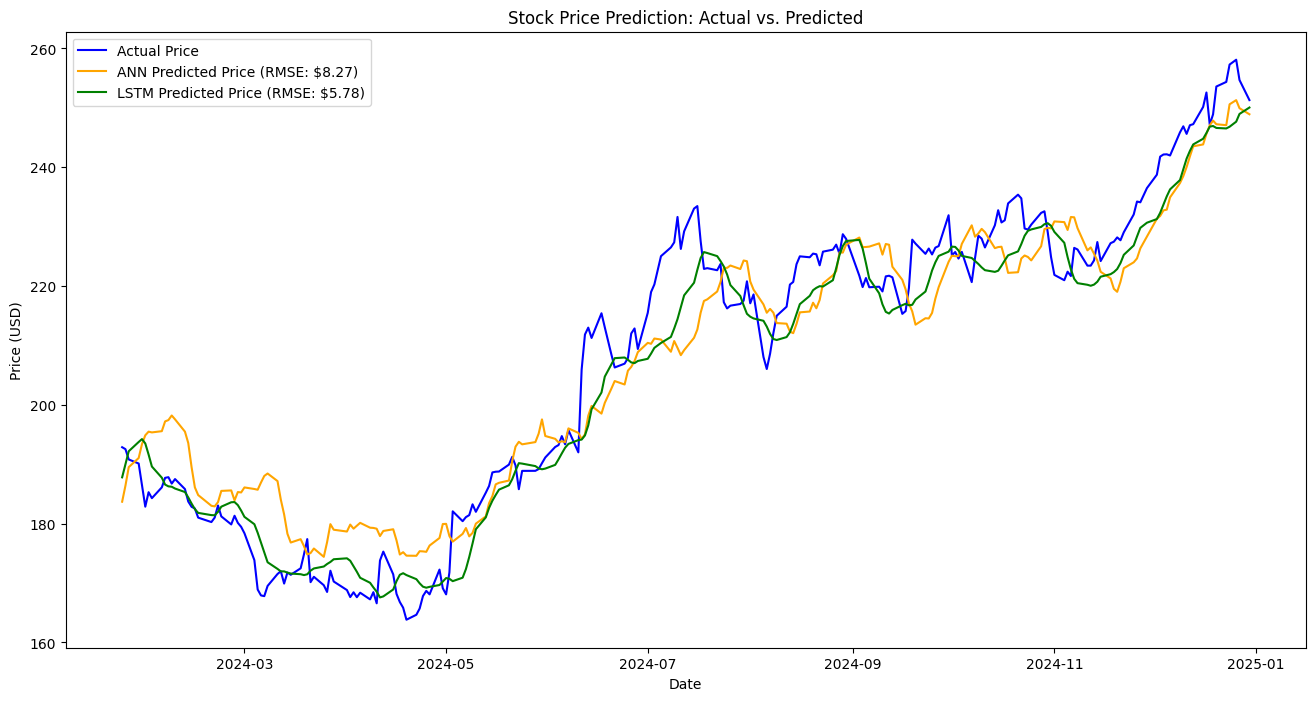

In [ ]:
# Make predictions
ann_predictions = ann_model.predict(X_test)
lstm_predictions = lstm_model.predict(X_test)

def inverse_transform_predictions(predictions, original_data_shape, scaler_instance):
    dummy_array = np.zeros((len(predictions), original_data_shape))
    dummy_array[:, 0] = predictions.ravel()
    return scaler_instance.inverse_transform(dummy_array)[:, 0]

# Inverse scale the predictions and the actual test values
ann_predictions_unscaled = inverse_transform_predictions(ann_predictions, len(features), scaler)
lstm_predictions_unscaled = inverse_transform_predictions(lstm_predictions, len(features), scaler)
y_test_unscaled = inverse_transform_predictions(y_test, len(features), scaler)

# Calculate RMSE
ann_rmse = np.sqrt(mean_squared_error(y_test_unscaled, ann_predictions_unscaled))
lstm_rmse = np.sqrt(mean_squared_error(y_test_unscaled, lstm_predictions_unscaled))

print("\n--- Model Performance ---")
print(f"ANN Model RMSE: ${ann_rmse:.2f}")
print(f"LSTM Model RMSE: ${lstm_rmse:.2f}")

# Plotting the results
dates = df.index[-len(y_test_unscaled):]

plt.figure(figsize=(16, 8))
plt.plot(dates, y_test_unscaled, color='blue', label='Actual Price')
plt.plot(dates, ann_predictions_unscaled, color='orange', label=f'ANN Predicted Price (RMSE: ${ann_rmse:.2f})')
plt.plot(dates, lstm_predictions_unscaled, color='green', label=f'LSTM Predicted Price (RMSE: ${lstm_rmse:.2f})')
plt.title('Stock Price Prediction: Actual vs. Predicted')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import mean_absolute_error, r2_score

# Calculate Mean Absolute Error (MAE)
ann_mae = mean_absolute_error(y_test_unscaled, ann_predictions_unscaled)
lstm_mae = mean_absolute_error(y_test_unscaled, lstm_predictions_unscaled)

# Calculate R-squared (R²) Score
ann_r2 = r2_score(y_test_unscaled, ann_predictions_unscaled)
lstm_r2 = r2_score(y_test_unscaled, lstm_predictions_unscaled)

print("--- ANN Model Performance ---")
print(f"RMSE: ${ann_rmse:.2f}")
print(f"MAE:  ${ann_mae:.2f}")
print(f"R-squared (R²): {ann_r2:.4f}")

print("\n--- LSTM Model Performance ---")
print(f"RMSE: ${lstm_rmse:.2f}")
print(f"MAE:  ${lstm_mae:.2f}")
print(f"R-squared (R²): {lstm_r2:.4f}")

--- ANN Model Performance ---
RMSE: $8.27
MAE:  $6.94
R-squared (R²): 0.8962

--- LSTM Model Performance ---
RMSE: $5.78
MAE:  $4.60
R-squared (R²): 0.9493


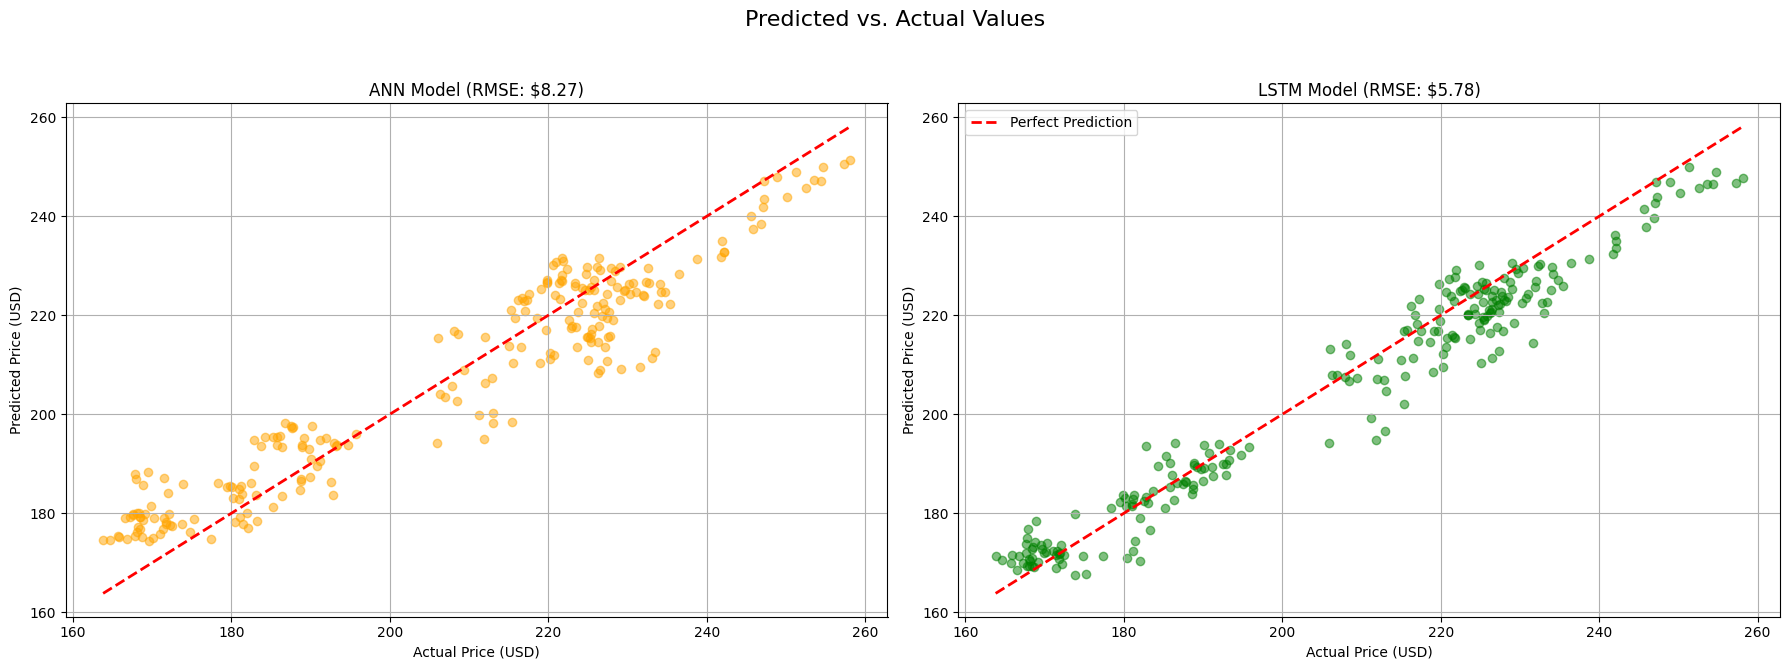

In [ ]:
# Create a figure with two subplots side-by-side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))
fig.suptitle('Predicted vs. Actual Values', fontsize=16)

# --- ANN Scatter Plot ---
ax1.scatter(y_test_unscaled, ann_predictions_unscaled, alpha=0.5, color='orange')
ax1.plot([y_test_unscaled.min(), y_test_unscaled.max()], [y_test_unscaled.min(), y_test_unscaled.max()], 'r--', lw=2)
ax1.set_title(f'ANN Model (RMSE: ${ann_rmse:.2f})')
ax1.set_xlabel('Actual Price (USD)')
ax1.set_ylabel('Predicted Price (USD)')
ax1.grid(True)

# --- LSTM Scatter Plot ---
ax2.scatter(y_test_unscaled, lstm_predictions_unscaled, alpha=0.5, color='green')
ax2.plot([y_test_unscaled.min(), y_test_unscaled.max()], [y_test_unscaled.min(), y_test_unscaled.max()], 'r--', lw=2, label='Perfect Prediction')
ax2.set_title(f'LSTM Model (RMSE: ${lstm_rmse:.2f})')
ax2.set_xlabel('Actual Price (USD)')
ax2.set_ylabel('Predicted Price (USD)')
ax2.legend()
ax2.grid(True)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()